[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/style-transfer/blob/master/styletransfer.ipynb)

In [2]:
!pip install torch
!pip install torchvision
!pip install pillow==4.0.0


    100% |████████████████████████████████| 5.6MB 6.7MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
from torchvision import transforms,models
import torch.optim as optim
from PIL import Image
import copy



In [0]:
device=torch.device('cuda:0' if torch.cuda.is_available() else'cpu')


In [0]:
imagesize=512 if torch.cuda.is_available() else 128
transform=transforms.Compose([transforms.Resize(imagesize),transforms.ToTensor()])

def imageloader(image):
  image=Image.open(image)
  image=transform(image)
  image=image.unsqueeze(0)
  
  return image.to(device)
  
  
style=imageloader('drive/app/picasso.jpg')
content=imageloader('drive/app/dancing.jpg')

assert style.size()==content.size(), "style and content image should be of same size"




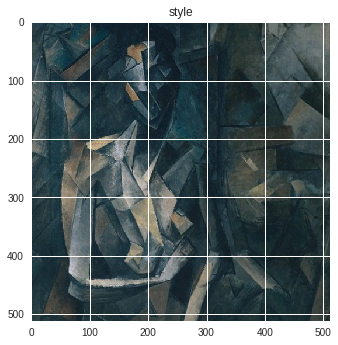

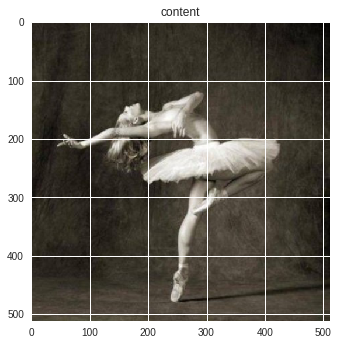

In [4]:
plt.ion()
untransform= transforms.ToPILImage()

def imageshow(image,imagetype):
  image=image.cpu().clone()
  image=image.squeeze(0)
  image=untransform(image)
  plt.title(imagetype)
  plt.imshow(image)
  
plt.figure()
imageshow(style,'style')
plt.figure()
imageshow(content,'content')
plt.show()


In [0]:
cnn=models.vgg19(pretrained=True).features.to(device).train()


In [0]:
class contentloss(nn.Module):
  def __init__(self,target):
    super(contentloss,self).__init__()
    self.target=target.detach()
  def forward(self,inputs):
    criterion=nn.MSELoss()
    self.loss=criterion(inputs,self.target)
    return inputs
  
class styleloss(nn.Module):
  def __init__(self,target):
    super(styleloss,self).__init__()
    self.target=target.detach()
  def forward(self,inputs):
    criterion=nn.MSELoss()
    self.loss=criterion(grammatrix(inputs),grammatrix(self.target))
    return inputs
  
  
def grammatrix(inputs):
  a,b,c,d=inputs.size()
  featuremap=inputs.view(a*b,c*d)
  matrixmal=torch.mm(featuremap,featuremap.t())
  return matrixmal/(a*b*c*d)

mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
std=torch.tensor([0.229, 0.224, 0.225]).to(device)
class normaliz(nn.Module):
  def __init__(self,mean,std):
    super(normaliz,self).__init__()
    self.mean=mean.view(-1,1,1)
    self.std=std.view(-1,1,1)
    
  def forward(self,inputs):
    return (inputs-self.mean)/self.std
    
    



In [0]:
content_layer=['conv_1','conv_2','conv_3','conv_4','conv_5']
style_layer=['conv_1','conv_2','conv_3','conv_4','conv_5']

def makingnewmodel(cnn,mean,std,style,content,style_layer,content_layer):
  cnn=copy.deepcopy(cnn)
  norma=normaliz(mean,std).to(device)
  
  newmodel=nn.Sequential(norma).to(device)
  closs=[]
  sloss=[]
  i=0
  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i+=1
      name='conv_{}'.format(i)
    elif isinstance(layer,nn.ReLU):
      name='relu_{}'.format(i)
      layer=nn.ReLU(inplace=False)
    elif isinstance(layer,nn.MaxPool2d):
      name='maxpool_{}'.format(i)
    elif isinstance(layer,nn.BatchNorm2d):
      name='bn_{}'.format(i)
    else:
      raise RuntimeError
      
    newmodel.add_module(name,layer)
    
   
    if name in content_layer:
         
         target= newmodel(content).detach()
         cl=contentloss(target).to(device)
         newmodel.add_module('content_loss{}'.format(i),cl)
         closs.append(cl)
    if name in style_layer:
         target= newmodel(content).detach()
         sl=styleloss(target).to(device)
         newmodel.add_module('style_loss{}'.format(i),sl)
         sloss.append(sl)
  for i in range(len(newmodel)-1,-1,-1):
    if isinstance(newmodel[i],contentloss) or isinstance(newmodel[i],styleloss):
       break
    newmodel=newmodel[:(i+1)]
  return newmodel,sloss,closs
        

In [0]:
inimg=content.clone()
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

def styletransfer(vcnn,mean,std,content,style,inimage,num_step=400,styleweight=1000,contentweight=1):
  model,styleloss,contentloss=makingnewmodel(vcnn,mean,std,style,content,style_layer,content_layer)
  optimizer=get_input_optimizer(inimage)
  for i in range(num_step):
     def closure():
       inimage.data.clamp_(0,1)
       
       optimizer.zero_grad()
       model(inimage)
       stylesc=0
       contsc=0
       for score in styleloss:
         stylesc+=score.loss
         
       for score in contentloss:
         contsc+=score.loss
         
       loss=stylesc*styleweight + contsc*contentweight
       
       loss.backward()
     optimizer.step(closure)
  inimage.data.clamp_(0,1)
  return inimage

In [62]:
image=styletransfer(cnn,mean,std,content,style,inimg)
plt.figure()
imageshow(image,'transformed version')
plt.show()

TypeError: ignored